In [1]:
import netCDF4 as nc
from netCDF4 import num2date,date2index
import datetime
import csv
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.initializers import glorot_uniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

2024-01-10 11:18:10.169793: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 11:18:10.170952: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 11:18:10.189508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 11:18:10.189535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 11:18:10.190264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
vwind = nc.Dataset('Vwind.nc')
slp = nc.Dataset('AirT.nc')

In [3]:
vwind

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121013
    title: monthly mean vwnd.10m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 11-Dec-2023 06:47:32 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 vwnd(time, lat, lon)
    groups: 

In [4]:
slp

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121012
    title: monthly mean air.2m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 16-Jun-2023 03:11:00 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 air(time, lat, lon)
    groups: 

In [5]:
v_wind = vwind.variables['vwnd']
print(vwind)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121013
    title: monthly mean vwnd.10m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 11-Dec-2023 06:47:32 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 vwnd(time, lat, lon)
    groups: 


In [6]:
slp_ = slp.variables['air']
print(slp)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121012
    title: monthly mean air.2m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 16-Jun-2023 03:11:00 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 air(time, lat, lon)
    groups: 


In [7]:
latitude = vwind.variables['lat']
print(latitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    actual_range: [ 88.542 -88.542]
unlimited dimensions: 
current shape = (94,)
filling off


In [8]:
latitude[:].shape

(94,)

In [9]:
latitude[:]

masked_array(data=[ 88.542   ,  86.6531  ,  84.7532  ,  82.8508  ,
                    80.9473  ,  79.0435  ,  77.1394  ,  75.2351  ,
                    73.3307  ,  71.4262  ,  69.5217  ,  67.6171  ,
                    65.7125  ,  63.8079  ,  61.9033  ,  59.9986  ,
                    58.0939  ,  56.1893  ,  54.2846  ,  52.3799  ,
                    50.4752  ,  48.5705  ,  46.6658  ,  44.7611  ,
                    42.8564  ,  40.9517  ,  39.047   ,  37.1422  ,
                    35.2375  ,  33.3328  ,  31.4281  ,  29.5234  ,
                    27.6186  ,  25.7139  ,  23.8092  ,  21.9044  ,
                    19.9997  ,  18.095   ,  16.1902  ,  14.2855  ,
                    12.3808  ,  10.47604 ,   8.57131 ,   6.66657 ,
                     4.76184 ,   2.8571  ,   0.952368,  -0.952368,
                    -2.8571  ,  -4.76184 ,  -6.66657 ,  -8.57131 ,
                   -10.47604 , -12.3808  , -14.2855  , -16.1902  ,
                   -18.095   , -19.9997  , -21.9044  , -23.809

In [10]:
latitude_slp = slp.variables['lat']
print(latitude_slp)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    actual_range: [ 88.542 -88.542]
unlimited dimensions: 
current shape = (94,)
filling off


In [11]:
latitude_slp[:].shape

(94,)

In [12]:
latitude_slp[:]

masked_array(data=[ 88.542   ,  86.6531  ,  84.7532  ,  82.8508  ,
                    80.9473  ,  79.0435  ,  77.1394  ,  75.2351  ,
                    73.3307  ,  71.4262  ,  69.5217  ,  67.6171  ,
                    65.7125  ,  63.8079  ,  61.9033  ,  59.9986  ,
                    58.0939  ,  56.1893  ,  54.2846  ,  52.3799  ,
                    50.4752  ,  48.5705  ,  46.6658  ,  44.7611  ,
                    42.8564  ,  40.9517  ,  39.047   ,  37.1422  ,
                    35.2375  ,  33.3328  ,  31.4281  ,  29.5234  ,
                    27.6186  ,  25.7139  ,  23.8092  ,  21.9044  ,
                    19.9997  ,  18.095   ,  16.1902  ,  14.2855  ,
                    12.3808  ,  10.47604 ,   8.57131 ,   6.66657 ,
                     4.76184 ,   2.8571  ,   0.952368,  -0.952368,
                    -2.8571  ,  -4.76184 ,  -6.66657 ,  -8.57131 ,
                   -10.47604 , -12.3808  , -14.2855  , -16.1902  ,
                   -18.095   , -19.9997  , -21.9044  , -23.809

In [13]:
longitude = vwind.variables['lon']
print(longitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    actual_range: [  0.    358.125]
unlimited dimensions: 
current shape = (192,)
filling off


In [14]:
longitude[:]

masked_array(data=[  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,
                    11.25 ,  13.125,  15.   ,  16.875,  18.75 ,  20.625,
                    22.5  ,  24.375,  26.25 ,  28.125,  30.   ,  31.875,
                    33.75 ,  35.625,  37.5  ,  39.375,  41.25 ,  43.125,
                    45.   ,  46.875,  48.75 ,  50.625,  52.5  ,  54.375,
                    56.25 ,  58.125,  60.   ,  61.875,  63.75 ,  65.625,
                    67.5  ,  69.375,  71.25 ,  73.125,  75.   ,  76.875,
                    78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,
                    90.   ,  91.875,  93.75 ,  95.625,  97.5  ,  99.375,
                   101.25 , 103.125, 105.   , 106.875, 108.75 , 110.625,
                   112.5  , 114.375, 116.25 , 118.125, 120.   , 121.875,
                   123.75 , 125.625, 127.5  , 129.375, 131.25 , 133.125,
                   135.   , 136.875, 138.75 , 140.625, 142.5  , 144.375,
                   146.25 , 148.125, 150.   , 151.8

In [15]:
longitude_slp = slp.variables['lon']
print(longitude_slp)

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    actual_range: [  0.    358.125]
unlimited dimensions: 
current shape = (192,)
filling off


In [16]:
longitude_slp[:]

masked_array(data=[  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,
                    11.25 ,  13.125,  15.   ,  16.875,  18.75 ,  20.625,
                    22.5  ,  24.375,  26.25 ,  28.125,  30.   ,  31.875,
                    33.75 ,  35.625,  37.5  ,  39.375,  41.25 ,  43.125,
                    45.   ,  46.875,  48.75 ,  50.625,  52.5  ,  54.375,
                    56.25 ,  58.125,  60.   ,  61.875,  63.75 ,  65.625,
                    67.5  ,  69.375,  71.25 ,  73.125,  75.   ,  76.875,
                    78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,
                    90.   ,  91.875,  93.75 ,  95.625,  97.5  ,  99.375,
                   101.25 , 103.125, 105.   , 106.875, 108.75 , 110.625,
                   112.5  , 114.375, 116.25 , 118.125, 120.   , 121.875,
                   123.75 , 125.625, 127.5  , 129.375, 131.25 , 133.125,
                   135.   , 136.875, 138.75 , 140.625, 142.5  , 144.375,
                   146.25 , 148.125, 150.   , 151.8

In [17]:
time = vwind.variables['time']
time_ = time[:]
time_units = time.units
time_calendar = time.calendar
time_dates = num2date(time_, units=time_units, calendar=time_calendar)
start_date = datetime.datetime(1958, 1, 1)
start_index = date2index(start_date, time, select='nearest')
air_subset = vwind['vwnd'][start_index:, :, :]

In [18]:
slp_subset = slp['air'][start_index:, :, :]

In [19]:
data_slp = np.array(slp_subset)

In [20]:
data_ = np.array(air_subset)
data_[data_ == -9.96921e+36] = 0

In [21]:
for date in time_dates:
    print(date)

1958-01-01 00:00:00
1958-02-01 00:00:00
1958-03-01 00:00:00
1958-04-01 00:00:00
1958-05-01 00:00:00
1958-06-01 00:00:00
1958-07-01 00:00:00
1958-08-01 00:00:00
1958-09-01 00:00:00
1958-10-01 00:00:00
1958-11-01 00:00:00
1958-12-01 00:00:00
1959-01-01 00:00:00
1959-02-01 00:00:00
1959-03-01 00:00:00
1959-04-01 00:00:00
1959-05-01 00:00:00
1959-06-01 00:00:00
1959-07-01 00:00:00
1959-08-01 00:00:00
1959-09-01 00:00:00
1959-10-01 00:00:00
1959-11-01 00:00:00
1959-12-01 00:00:00
1960-01-01 00:00:00
1960-02-01 00:00:00
1960-03-01 00:00:00
1960-04-01 00:00:00
1960-05-01 00:00:00
1960-06-01 00:00:00
1960-07-01 00:00:00
1960-08-01 00:00:00
1960-09-01 00:00:00
1960-10-01 00:00:00
1960-11-01 00:00:00
1960-12-01 00:00:00
1961-01-01 00:00:00
1961-02-01 00:00:00
1961-03-01 00:00:00
1961-04-01 00:00:00
1961-05-01 00:00:00
1961-06-01 00:00:00
1961-07-01 00:00:00
1961-08-01 00:00:00
1961-09-01 00:00:00
1961-10-01 00:00:00
1961-11-01 00:00:00
1961-12-01 00:00:00
1962-01-01 00:00:00
1962-02-01 00:00:00


In [22]:
data_

array([[[-1.4929032 , -1.430321  , -1.3654824 , ..., -1.6870934 ,
         -1.62032   , -1.5587075 ],
        [-1.5558048 , -1.512902  , -1.4638692 , ..., -1.6525791 ,
         -1.623547  , -1.5906432 ],
        [-2.166773  , -2.1119325 , -2.032579  , ..., -2.266128  ,
         -2.2525797 , -2.223869  ],
        ...,
        [-2.8790312 , -2.9438698 , -2.9948366 , ..., -2.6635466 ,
         -2.7425802 , -2.8193536 ],
        [-2.3087094 , -2.3729007 , -2.433223  , ..., -2.0841925 ,
         -2.1648378 , -2.2345147 ],
        [-1.6467713 , -1.6641924 , -1.6809658 , ..., -1.5806437 ,
         -1.608708  , -1.6322563 ]],

       [[-0.8264269 , -0.80321175, -0.7767852 , ..., -0.91606957,
         -0.88321143, -0.84821373],
        [-0.7364268 , -0.74857   , -0.7660691 , ..., -0.677857  ,
         -0.686427  , -0.7092852 ],
        [-0.99285614, -1.036069  , -1.0657136 , ..., -0.81892616,
         -0.887855  , -0.9464264 ],
        ...,
        [-2.199641  , -2.1664271 , -2.1453557 , ..., -

In [23]:
data_slp

array([[[242.67839, 242.67741, 242.65549, ..., 242.74127, 242.71709,
         242.69644],
        [243.68414, 243.68127, 243.67902, ..., 243.6503 , 243.6819 ,
         243.69708],
        [245.25447, 245.32898, 245.41322, ..., 245.10028, 245.16899,
         245.2345 ],
        ...,
        [257.8329 , 258.05096, 258.26257, ..., 257.24097, 257.42807,
         257.6313 ],
        [258.0322 , 258.11777, 258.2148 , ..., 257.84323, 257.89645,
         257.9648 ],
        [257.93512, 257.9254 , 257.91937, ..., 257.96323, 257.95227,
         257.9429 ]],

       [[237.96216, 237.95569, 237.9528 , ..., 237.955  , 237.94217,
         237.96141],
        [237.40498, 237.54497, 237.67213, ..., 236.95248, 237.09282,
         237.2539 ],
        [238.65605, 238.98608, 239.29248, ..., 237.69926, 238.01817,
         238.34322],
        ...,
        [234.59033, 234.6957 , 234.79604, ..., 234.65785, 234.5586 ,
         234.54285],
        [235.72789, 235.5986 , 235.48856, ..., 236.20923, 236.02783,
   

In [24]:
np.max(data_)

14.949664

In [25]:
np.min(data_)

-13.041287

In [26]:
np.max(data_slp)

313.74673

In [27]:
np.min(data_slp)

187.4545

In [28]:
data_.shape

(708, 94, 192)

In [29]:
data_slp.shape

(708, 94, 192)

In [30]:
len(data_)

708

In [31]:
num_years = data_.shape[0] // 12
num_months = data_.shape[0] // num_years

In [32]:
num_years

59

In [33]:
num_months

12

In [34]:
data_reshaped = np.reshape(data_, (len(data_) // 12, 12, data_.shape[1],data_.shape[2]))

In [35]:
data_reshaped_slp = np.reshape(data_slp, (len(data_) // 12, 12, data_slp.shape[1],data_slp.shape[2]))

In [36]:
lat_indices = []
for start_value in np.arange(90, -90, -10):  # Changed step to -10 for descending order
    end_value = start_value - 10  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((latitude <= start_value) & (latitude >= end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmax(latitude[range_indices])]
        max_index = range_indices[np.argmin(latitude[range_indices])]
        
        lat_indices.append(min_index)
        lat_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {latitude[min_index]}, Max = {latitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 90 to 80: Min index = 0, Max index = 4, Min = 88.54199981689453, Max = 80.94730377197266
Range 80 to 70: Min index = 5, Max index = 9, Min = 79.04350280761719, Max = 71.42620086669922
Range 70 to 60: Min index = 10, Max index = 14, Min = 69.52169799804688, Max = 61.90330123901367
Range 60 to 50: Min index = 15, Max index = 20, Min = 59.998600006103516, Max = 50.47520065307617
Range 50 to 40: Min index = 21, Max index = 25, Min = 48.570499420166016, Max = 40.951698303222656
Range 40 to 30: Min index = 26, Max index = 30, Min = 39.047000885009766, Max = 31.4281005859375
Range 30 to 20: Min index = 31, Max index = 35, Min = 29.523399353027344, Max = 21.904399871826172
Range 20 to 10: Min index = 36, Max index = 41, Min = 19.99970054626465, Max = 10.47603988647461
Range 10 to 0: Min index = 42, Max index = 46, Min = 8.571310043334961, Max = 0.9523680210113525
Range 0 to -10: Min index = 47, Max index = 51, Min = -0.9523680210113525, Max = -8.571310043334961
Range -10 to -20: Min inde

In [37]:
lat_indices_slp = []
for start_value in np.arange(90, -90, -10):  # Changed step to -10 for descending order
    end_value = start_value - 10  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((latitude_slp <= start_value) & (latitude_slp > end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmax(latitude_slp[range_indices])]
        max_index = range_indices[np.argmin(latitude_slp[range_indices])]
        
        lat_indices_slp.append(min_index)
        lat_indices_slp.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {latitude_slp[min_index]}, Max = {latitude_slp[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 90 to 80: Min index = 0, Max index = 4, Min = 88.54199981689453, Max = 80.94730377197266
Range 80 to 70: Min index = 5, Max index = 9, Min = 79.04350280761719, Max = 71.42620086669922
Range 70 to 60: Min index = 10, Max index = 14, Min = 69.52169799804688, Max = 61.90330123901367
Range 60 to 50: Min index = 15, Max index = 20, Min = 59.998600006103516, Max = 50.47520065307617
Range 50 to 40: Min index = 21, Max index = 25, Min = 48.570499420166016, Max = 40.951698303222656
Range 40 to 30: Min index = 26, Max index = 30, Min = 39.047000885009766, Max = 31.4281005859375
Range 30 to 20: Min index = 31, Max index = 35, Min = 29.523399353027344, Max = 21.904399871826172
Range 20 to 10: Min index = 36, Max index = 41, Min = 19.99970054626465, Max = 10.47603988647461
Range 10 to 0: Min index = 42, Max index = 46, Min = 8.571310043334961, Max = 0.9523680210113525
Range 0 to -10: Min index = 47, Max index = 51, Min = -0.9523680210113525, Max = -8.571310043334961
Range -10 to -20: Min inde

In [38]:
lat_indices

[0,
 4,
 5,
 9,
 10,
 14,
 15,
 20,
 21,
 25,
 26,
 30,
 31,
 35,
 36,
 41,
 42,
 46,
 47,
 51,
 52,
 57,
 58,
 62,
 63,
 67,
 68,
 72,
 73,
 78,
 79,
 83,
 84,
 88,
 89,
 93]

In [39]:
lat_indices_slp

[0,
 4,
 5,
 9,
 10,
 14,
 15,
 20,
 21,
 25,
 26,
 30,
 31,
 35,
 36,
 41,
 42,
 46,
 47,
 51,
 52,
 57,
 58,
 62,
 63,
 67,
 68,
 72,
 73,
 78,
 79,
 83,
 84,
 88,
 89,
 93]

In [40]:
len(lat_indices)

36

In [41]:
len(lat_indices_slp)

36

In [42]:
lon_indices = []
for start_value in np.arange(0, 360, 20):  # Changed step to -10 for descending order
    end_value = start_value + 20  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((longitude >= start_value) & (longitude < end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmin(longitude[range_indices])]
        max_index = range_indices[np.argmax(longitude[range_indices])]
        
        lon_indices.append(min_index)
        lon_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {longitude[min_index]}, Max = {longitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 0 to 20: Min index = 0, Max index = 10, Min = 0.0, Max = 18.75
Range 20 to 40: Min index = 11, Max index = 21, Min = 20.625, Max = 39.375
Range 40 to 60: Min index = 22, Max index = 31, Min = 41.25, Max = 58.125
Range 60 to 80: Min index = 32, Max index = 42, Min = 60.0, Max = 78.75
Range 80 to 100: Min index = 43, Max index = 53, Min = 80.625, Max = 99.375
Range 100 to 120: Min index = 54, Max index = 63, Min = 101.25, Max = 118.125
Range 120 to 140: Min index = 64, Max index = 74, Min = 120.0, Max = 138.75
Range 140 to 160: Min index = 75, Max index = 85, Min = 140.625, Max = 159.375
Range 160 to 180: Min index = 86, Max index = 95, Min = 161.25, Max = 178.125
Range 180 to 200: Min index = 96, Max index = 106, Min = 180.0, Max = 198.75
Range 200 to 220: Min index = 107, Max index = 117, Min = 200.625, Max = 219.375
Range 220 to 240: Min index = 118, Max index = 127, Min = 221.25, Max = 238.125
Range 240 to 260: Min index = 128, Max index = 138, Min = 240.0, Max = 258.75
Range 2

In [43]:
lon_indices_slp = []
for start_value in np.arange(0, 360, 20):  # Changed step to -10 for descending order
    end_value = start_value + 20  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((longitude_slp >= start_value) & (longitude_slp < end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmin(longitude_slp[range_indices])]
        max_index = range_indices[np.argmax(longitude_slp[range_indices])]
        
        lon_indices_slp.append(min_index)
        lon_indices_slp.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {longitude_slp[min_index]}, Max = {longitude_slp[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 0 to 20: Min index = 0, Max index = 10, Min = 0.0, Max = 18.75
Range 20 to 40: Min index = 11, Max index = 21, Min = 20.625, Max = 39.375
Range 40 to 60: Min index = 22, Max index = 31, Min = 41.25, Max = 58.125
Range 60 to 80: Min index = 32, Max index = 42, Min = 60.0, Max = 78.75
Range 80 to 100: Min index = 43, Max index = 53, Min = 80.625, Max = 99.375
Range 100 to 120: Min index = 54, Max index = 63, Min = 101.25, Max = 118.125
Range 120 to 140: Min index = 64, Max index = 74, Min = 120.0, Max = 138.75
Range 140 to 160: Min index = 75, Max index = 85, Min = 140.625, Max = 159.375
Range 160 to 180: Min index = 86, Max index = 95, Min = 161.25, Max = 178.125
Range 180 to 200: Min index = 96, Max index = 106, Min = 180.0, Max = 198.75
Range 200 to 220: Min index = 107, Max index = 117, Min = 200.625, Max = 219.375
Range 220 to 240: Min index = 118, Max index = 127, Min = 221.25, Max = 238.125
Range 240 to 260: Min index = 128, Max index = 138, Min = 240.0, Max = 258.75
Range 2

In [44]:
lon_indices

[0,
 10,
 11,
 21,
 22,
 31,
 32,
 42,
 43,
 53,
 54,
 63,
 64,
 74,
 75,
 85,
 86,
 95,
 96,
 106,
 107,
 117,
 118,
 127,
 128,
 138,
 139,
 149,
 150,
 159,
 160,
 170,
 171,
 181,
 182,
 191]

In [45]:
lon_indices_slp

[0,
 10,
 11,
 21,
 22,
 31,
 32,
 42,
 43,
 53,
 54,
 63,
 64,
 74,
 75,
 85,
 86,
 95,
 96,
 106,
 107,
 117,
 118,
 127,
 128,
 138,
 139,
 149,
 150,
 159,
 160,
 170,
 171,
 181,
 182,
 191]

In [46]:
len(lon_indices)

36

In [47]:
len(lon_indices_slp)

36

In [48]:
for lat_idx in range(0, len(lat_indices), 2):
    lat_range_start = lat_indices[lat_idx]
    lat_range_end = lat_indices[lat_idx + 1]
    print(lat_range_start,lat_range_end)

0 4
5 9
10 14
15 20
21 25
26 30
31 35
36 41
42 46
47 51
52 57
58 62
63 67
68 72
73 78
79 83
84 88
89 93


In [49]:
for lon_idx in range(0, len(lon_indices),2):
    lon_range_start = lon_indices[lon_idx]
    lon_range_end = lon_indices[lon_idx + 1]
    print(lon_range_start,lon_range_end)

0 10
11 21
22 31
32 42
43 53
54 63
64 74
75 85
86 95
96 106
107 117
118 127
128 138
139 149
150 159
160 170
171 181
182 191


In [50]:
def coarse_gridding(data, lat_indices, lon_indices):
    coarsed_data = np.zeros((data.shape[0], data.shape[1], len(lat_indices) // 2, len(lon_indices) // 2))
    for lat_idx in range(0, len(lat_indices), 2):
        lat_range_start = lat_indices[lat_idx]
        lat_range_end = lat_indices[lat_idx + 1]
        for lon_idx in range(0, len(lon_indices), 2):
            lon_range_start = lon_indices[lon_idx]
            lon_range_end = lon_indices[lon_idx + 1]
            subset = data[:, :, lat_range_start:lat_range_end, lon_range_start:lon_range_end]
            averaged_value = np.mean(subset, axis=(2, 3))
            coarsed_data[:, :, lat_idx // 2, lon_idx // 2] = averaged_value
    return coarsed_data


In [51]:
 avg = coarse_gridding(data_reshaped,lat_indices,lon_indices)

In [52]:
 avg_slp = coarse_gridding(data_reshaped_slp,lat_indices_slp,lon_indices_slp)

In [53]:
avg.shape

(59, 12, 18, 18)

In [54]:
avg_slp.shape

(59, 12, 18, 18)

In [55]:
avg[1,1,:,1]

array([-1.37579322, -0.37761432,  0.98259962, -0.7188341 , -2.39035559,
       -3.6570785 , -2.55940938, -3.06712699,  0.72156376, -0.13419506,
       -0.67897719,  0.2955018 ,  0.73510867, -1.17009699, -3.58016276,
       -1.2948916 ,  2.14891195, -3.18188238])

In [56]:
avg_slp[1,1,:,1]

array([237.91757202, 260.10202026, 268.48214722, 268.39157104,
       271.36395264, 279.28863525, 283.61322021, 293.53561401,
       296.75665283, 294.19985962, 294.51821899, 296.90673828,
       294.46496582, 284.94174194, 276.02813721, 273.51663208,
       245.37313843, 237.2964325 ])

In [57]:
final= np.reshape(avg, (len(data_) // 12, 12, 324))

In [58]:
final_slp= np.reshape(avg_slp, (len(data_slp) // 12, 12, 324))

In [59]:
final.shape

(59, 12, 324)

In [60]:
final_slp.shape

(59, 12, 324)

In [61]:
np.max(final)

10.61324691772461

In [62]:
np.max(final_slp)

308.5638732910156

In [63]:
np.min(final)

-9.84632396697998

In [64]:
np.min(final_slp)

200.49240112304688

In [65]:
ff= final.reshape(324,708)
ff.shape

(324, 708)

In [66]:
ff_slp= final_slp.reshape(324,708)
ff_slp.shape

(324, 708)

In [67]:
def calculate_monthly_anomaliess(data):
    """Calculate monthly anomalies and mean for a given dataset.

    Args:
        data: A multidimensional array with dimensions (years, months, latlon).

    Returns:
        monthly_anomalies: An array with monthly anomalies of the same shape as the input data.
        monthly_mean: A multidimensional array with dimensions (months, latlon) representing the mean for each month.
    """


    anomalies = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]
            monthly_mean = np.mean(month)
            anomalies[:, j, i] = month - monthly_mean
    return anomalies

def min_max_normalize(data):
    normalized_data = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]

            # Calculate min and max values for each month
            min_value = np.min(month)
            max_value = np.max(month)

            # Normalize each month value
            normalized_month = (month - min_value) / (max_value - min_value)

            # Store normalized month data
            normalized_data[:, j, i] = normalized_month


    return normalized_data




In [68]:
anomalies = calculate_monthly_anomaliess(final)
anomalies

array([[[-0.61842849, -0.04224145,  0.41977062, ...,  0.21886257,
          0.77723606,  0.03453125],
        [ 0.16409761, -0.47422842, -0.83740196, ...,  0.96947426,
          0.98287361,  0.97848601],
        [ 0.49842839, -0.35413977, -1.05812023, ..., -0.13123625,
         -0.16897358, -0.10431352],
        ...,
        [ 0.74166578,  0.67409025,  0.54422327, ...,  0.3723519 ,
          0.15264775, -0.06135368],
        [-0.44587413,  0.03843281,  0.62934187, ...,  0.45526068,
          1.05315812,  1.23521022],
        [ 0.07365013,  0.25072824,  0.11119684, ...,  0.3428079 ,
          0.91871043,  0.95196165]],

       [[-1.8463315 , -2.50595114, -2.39294467, ...,  0.06982226,
          0.13561488,  0.48681606],
        [-1.35814315, -1.06018392, -1.03488205, ...,  0.23898346,
         -0.29985876, -0.87810116],
        [-0.81204797, -1.68636545, -1.66338025, ...,  0.15278775,
         -0.22454609, -0.28190341],
        ...,
        [ 0.81768971,  1.23155786,  1.4624132 , ..., -

In [69]:
anomalies_slp = calculate_monthly_anomaliess(final_slp)
anomalies_slp

array([[[ 2.41490018,  1.50256813,  0.62712459, ...,  1.78126655,
          2.92965078,  4.79115011],
        [-2.24119128, -2.01722614, -1.83133943, ..., -2.137281  ,
         -1.61046174, -1.32883673],
        [ 1.82021836,  0.42056223,  0.12525759, ..., -0.20518054,
         -0.18625292, -0.15214616],
        ...,
        [-3.75099492, -3.45784617, -3.56042558, ...,  0.36721647,
         -0.26667527,  0.2699947 ],
        [-1.10312226, -1.41140126, -1.41203748, ..., -1.48686037,
         -1.79768889, -2.18447255],
        [ 0.13856455, -0.88789963, -1.29491153, ..., -2.27713168,
         -1.6681472 , -1.29694897]],

       [[-3.62797702, -3.14806663, -2.68969364, ...,  0.65333686,
          0.78273915,  0.67084982],
        [-3.58243884, -4.887206  , -5.82857759, ..., -1.39149242,
          0.34139678,  1.94789667],
        [-2.71127578, -1.83735708, -1.00383177, ..., -3.12745227,
         -1.54825243, -1.53434831],
        ...,
        [ 1.3275268 ,  1.70829152,  1.9839012 , ..., -

In [70]:
np.max((anomalies))

10.43126195893323

In [71]:
np.max((anomalies_slp))

16.290083287125924

In [72]:
np.min((anomalies))

-6.8846317913572666

In [73]:
np.min((anomalies_slp))

-16.870114342641017

In [74]:
num_positive_values = np.sum(anomalies > 0)

# Find the number of negative values
num_negative_values = np.sum(anomalies < 0)

# Find the number of zero values (optional)
num_zero_values = np.sum(anomalies == 0)

print("Number of positive values:", num_positive_values)
print("Number of negative values:", num_negative_values)
print("Number of zero values:", num_zero_values)

Number of positive values: 114469
Number of negative values: 114923
Number of zero values: 0


In [75]:
num_positive_values = np.sum(anomalies_slp > 0)

# Find the number of negative values
num_negative_values = np.sum(anomalies_slp < 0)

# Find the number of zero values (optional)
num_zero_values = np.sum(anomalies_slp == 0)

print("Number of positive values:", num_positive_values)
print("Number of negative values:", num_negative_values)
print("Number of zero values:", num_zero_values)

Number of positive values: 114794
Number of negative values: 114598
Number of zero values: 0


In [76]:


# Assuming normalized_data_slp and normalized_data_vwind are your arrays
# with shape (59, 12, 324)

combined_anomalies = np.concatenate((anomalies, anomalies_slp), axis=2)

# Now combined_data has shape (59, 12, 648)


In [77]:
normalized_data = min_max_normalize(combined_anomalies)
normalized_data

array([[[0.20848224, 0.32852639, 0.45617707, ..., 0.84572753,
         1.        , 1.        ],
        [0.41718784, 0.41832843, 0.37395431, ..., 0.28123542,
         0.13141923, 0.2612389 ],
        [0.60470888, 0.4645523 , 0.34006932, ..., 0.40550899,
         0.44986565, 0.51581615],
        ...,
        [0.70595635, 0.67382371, 0.56667777, ..., 0.56327253,
         0.42453261, 0.48744818],
        [0.44984909, 0.49066056, 0.54068982, ..., 0.26998777,
         0.26912402, 0.22772299],
        [0.37616461, 0.5164843 , 0.54904803, ..., 0.20006698,
         0.27479765, 0.34143807]],

       [[0.0290309 , 0.03999494, 0.11592706, ..., 0.62988507,
         0.66045659, 0.55682477],
        [0.18503122, 0.32788736, 0.34768372, ..., 0.36599468,
         0.42705531, 0.65961899],
        [0.40724127, 0.27680572, 0.2467628 , ..., 0.16697224,
         0.30811741, 0.36656984],
        ...,
        [0.72013696, 0.77250223, 0.71873184, ..., 0.42927895,
         0.40882087, 0.3019833 ],
        [0.5

In [78]:
tf.random.set_seed(12345)

In [79]:
input_dim = 648
hidden_dim = 65
input_layer = Input(shape = (input_dim,))
hidden_layer = Dense(hidden_dim,activation='tanh')(input_layer)
output_layer = Dense(input_dim,activation='linear')(hidden_layer)

2024-01-10 11:18:12.261967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 11:18:12.262248: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [80]:
input_data = normalized_data.reshape(-1, input_dim)
input_data.shape

(708, 648)

In [81]:
input_data

array([[0.20848224, 0.32852639, 0.45617707, ..., 0.84572753, 1.        ,
        1.        ],
       [0.41718784, 0.41832843, 0.37395431, ..., 0.28123542, 0.13141923,
        0.2612389 ],
       [0.60470888, 0.4645523 , 0.34006932, ..., 0.40550899, 0.44986565,
        0.51581615],
       ...,
       [0.84803264, 0.8664633 , 0.77546441, ..., 0.4996632 , 0.53602717,
        0.69165612],
       [0.90055362, 0.89270828, 0.85298858, ..., 1.        , 0.91804831,
        0.84808065],
       [0.51273029, 0.78491757, 1.        , ..., 0.78238981, 0.68243643,
        0.54931417]])

In [82]:
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [83]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [84]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 648)]             0         
                                                                 
 dense (Dense)               (None, 65)                42185     
                                                                 
 dense_1 (Dense)             (None, 648)               42768     
                                                                 
Total params: 84953 (331.85 KB)
Trainable params: 84953 (331.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
autoencoder.fit(input_data, input_data, epochs=10
                , batch_size=8)

Epoch 1/10
89/89 [==============================] - 0s 569us/step - loss: 0.0841
Epoch 2/10
89/89 [==============================] - 0s 526us/step - loss: 0.0502
Epoch 3/10
89/89 [==============================] - 0s 553us/step - loss: 0.0464
Epoch 4/10
89/89 [==============================] - 0s 432us/step - loss: 0.0431
Epoch 5/10
89/89 [==============================] - 0s 595us/step - loss: 0.0397
Epoch 6/10
89/89 [==============================] - 0s 416us/step - loss: 0.0367
Epoch 7/10
89/89 [==============================] - 0s 565us/step - loss: 0.0341
Epoch 8/10
89/89 [==============================] - 0s 574us/step - loss: 0.0322
Epoch 9/10
89/89 [==============================] - 0s 746us/step - loss: 0.0306
Epoch 10/10
89/89 [==============================] - 0s 877us/step - loss: 0.0291


In [86]:
encoded_data = autoencoder.predict(input_data)

23/23 [==============================] - 0s 356us/step


In [87]:
encoded_data.shape

(708, 648)

In [88]:
decoded_data = autoencoder.predict(encoded_data)

23/23 [==============================] - 0s 343us/step


In [89]:
decoded_data.shape

(708, 648)

In [90]:
weights = autoencoder.get_weights()[0]# Get the weights of the first layer (between input and hidden)
weights

array([[-0.04996783, -0.01973006, -0.05445005, ..., -0.04651295,
         0.01074614, -0.01224095],
       [ 0.09307133,  0.07133362,  0.0007684 , ..., -0.02047915,
        -0.03387039,  0.03170135],
       [ 0.04089291, -0.02674326,  0.04056565, ..., -0.03192099,
         0.03573745, -0.06880057],
       ...,
       [-0.06658666,  0.02342362, -0.06102831, ..., -0.07526722,
        -0.06941771, -0.06406978],
       [-0.0464781 ,  0.04001024, -0.05117789, ...,  0.04186757,
         0.03906999, -0.02149721],
       [ 0.09008046,  0.0654293 ,  0.04483607, ...,  0.05000547,
         0.00507441,  0.02880892]], dtype=float32)

In [91]:
np.save('weights.npy', weights)

In [92]:
weights = np.load('weights.npy')

In [93]:
weights

array([[-0.04996783, -0.01973006, -0.05445005, ..., -0.04651295,
         0.01074614, -0.01224095],
       [ 0.09307133,  0.07133362,  0.0007684 , ..., -0.02047915,
        -0.03387039,  0.03170135],
       [ 0.04089291, -0.02674326,  0.04056565, ..., -0.03192099,
         0.03573745, -0.06880057],
       ...,
       [-0.06658666,  0.02342362, -0.06102831, ..., -0.07526722,
        -0.06941771, -0.06406978],
       [-0.0464781 ,  0.04001024, -0.05117789, ...,  0.04186757,
         0.03906999, -0.02149721],
       [ 0.09008046,  0.0654293 ,  0.04483607, ...,  0.05000547,
         0.00507441,  0.02880892]], dtype=float32)

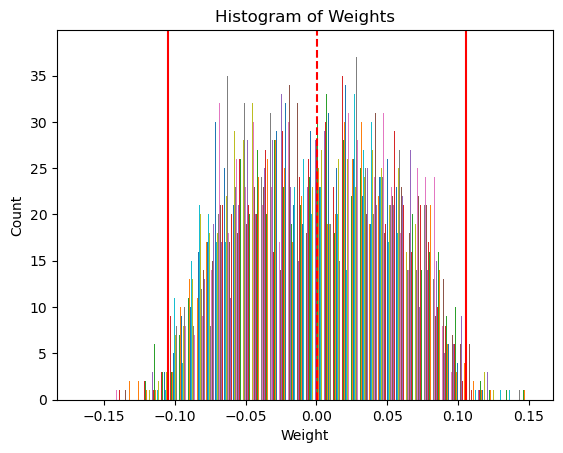

In [94]:
import matplotlib.pyplot as plt
# Calculate the mean and standard deviation of the weights.
mean = np.mean(weights)
sigma = np.std(weights)

# Plot a histogram of the weights.
plt.hist(weights, bins=50)
plt.axvline(mean, color='red', linestyle='dashed')
plt.axvline(mean + 2*sigma, color='red')
plt.axvline(mean - 2*sigma, color='red')
plt.title('Histogram of Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

In [95]:
weights.shape

(648, 65)

In [109]:
def Tweights(weight):
    num = []

    for i in range(weight.shape[1]):
        weight_mean = np.mean(weight[:, i])
        weight_std = np.std(weight[:, i])
        threshold_upper = weight_mean + 1.5 * weight_std
        threshold_lower = weight_mean - 1.5 * weight_std
        nodes_with_weight_above_upper_threshold = np.sum(weight[:, i] > threshold_upper)
        nodes_with_weight_below_lower_threshold = np.sum(weight[:, i] < threshold_lower)
        ten_percent_nodes = int(0.1 * weight.shape[0])

        if nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold > ten_percent_nodes:
            num.append(nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold)
            print(i, nodes_with_weight_above_upper_threshold, threshold_upper, nodes_with_weight_below_lower_threshold, threshold_lower)

    return num




In [110]:
we = Tweights(weights)
we

0 41 0.0789346433011815 34 -0.0753767864080146
1 38 0.07541025499813259 40 -0.08036377211101353
2 47 0.0791066299425438 49 -0.077701645786874
3 37 0.07930751197272912 47 -0.0796129810041748
4 44 0.08001218596473336 48 -0.0742879449389875
5 43 0.07991723602754064 34 -0.0807957325305324
6 47 0.0784495003754273 41 -0.07962734845932573
7 48 0.0770359065500088 47 -0.07536089530913159
8 46 0.07773757961695082 36 -0.0767946517735254
9 48 0.08032163023017347 38 -0.07515318528749049
10 48 0.07911592518212274 39 -0.0776607675361447
11 43 0.07939677545800805 43 -0.08039207151159644
12 45 0.07915831051650457 52 -0.07892472975072451
13 46 0.07634748046984896 52 -0.07622632483253255
14 18 0.09659092500805855 50 -0.06820553913712502
15 48 0.07926201913505793 42 -0.07247206475585699
16 29 0.09293357096612453 52 -0.06821398250758648
17 37 0.07356189144775271 48 -0.0782668967731297
18 42 0.07877289835596457 33 -0.07738718803739175
19 41 0.07450884068384767 44 -0.08169370284304023
20 47 0.074482277734205

[75,
 78,
 96,
 84,
 92,
 77,
 88,
 95,
 82,
 86,
 87,
 86,
 97,
 98,
 68,
 90,
 81,
 85,
 75,
 85,
 85,
 90,
 92,
 83,
 85,
 71,
 81,
 82,
 88,
 81,
 90,
 79,
 79,
 72,
 95,
 83,
 90,
 91,
 92,
 97,
 83,
 78,
 79,
 85,
 85,
 82,
 86,
 89,
 84,
 77,
 84,
 86,
 84,
 80,
 91,
 103,
 81,
 75,
 81,
 86,
 85,
 79,
 84,
 83,
 82]

In [111]:
len(we)

65

In [99]:
pred = np.zeros((65,708))
for i in range(weights.shape[1]):
    weight_mean = np.mean(weights[:,i])
    weight_std = np.std(weights[:,i])
    threshold_upper = weight_mean + 1.5 * weight_std
    threshold_lower = weight_mean - 1.5 * weight_std
    nodes_with_weight_above_upper_threshold = np.sum(weights[:, i] > threshold_upper)
    nodes_with_weight_below_lower_threshold = np.sum(weights[:, i] < threshold_lower)
    ten_percent_nodes = int(0.1 * weights.shape[0])
    if (nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold) > ten_percent_nodes:
        for h in range(input_data.shape[0]): 
            pred_i = 0
            for j in range(weights.shape[0]):
                weight_value = weights[j,i]
                if weight_value > threshold_upper or weight_value < threshold_lower:
                    pp = np.sum(weight_value*input_data[h,j])
                    pred_i += pp
                    pred[i,h] = pred_i
                

print(pred)

[[ 0.81558637  0.55680728  0.91464747 ...  0.52495856  0.9935884
   0.56360179]
 [-0.18327997 -0.10830182 -0.37000777 ... -0.1236294  -0.49022588
  -0.2678252 ]
 [ 0.38934857  0.01012304  0.00970933 ... -0.06799525 -0.48429579
   0.03383025]
 ...
 [ 0.92554802  0.77174127  0.75326588 ...  0.43820296  0.6132503
   0.47277537]
 [-0.78066077 -0.81089676 -0.54724755 ... -0.79953128 -0.8237266
  -0.46943338]
 [-0.01219373  0.24377416  0.39174672 ...  0.74504018  0.54329917
  -0.11100256]]


In [100]:
weight_value

0.028808923

In [101]:
number_of_zeros = np.count_nonzero( pred == 0)

In [102]:
number_of_zeros

0

In [103]:
pred.shape

(65, 708)

In [104]:
predd = pred[12,:].reshape(59,12)
predd

array([[ 0.00329798, -0.2375585 , -0.01964715, -0.23760825, -0.28839242,
        -0.21764566, -0.19175789, -0.24851273, -0.46294106, -0.79626042,
        -0.93891151, -0.63303937],
       [-0.00450999,  0.41370535, -0.14362677, -0.05577156, -0.24478612,
        -0.51887682, -0.42754   , -0.32148134, -1.11211256, -0.89940207,
        -0.49580254, -0.35837543],
       [-0.11800343, -0.76402968, -0.89649709,  0.01669317, -0.62246661,
        -0.97388595, -0.73805503, -0.63684771, -0.67552421, -1.12374694,
        -0.61443003, -0.65646607],
       [-0.55425476,  0.0264848 , -0.03140132, -0.30606879, -0.64837948,
        -0.21843839, -0.63766441, -1.07826538, -0.28216539, -0.30119088,
        -0.28586108, -0.69792605],
       [-0.93301148, -0.46465653, -0.74498935, -0.91923002, -1.35342129,
        -1.04307051, -1.12782933, -0.76067638, -0.79191348, -1.21132506,
        -0.96066035, -0.91369397],
       [-0.34339132, -0.96198674, -0.28083019, -0.65311634, -0.47112745,
        -0.75327392, -

In [112]:
df = pd.read_csv("enso_index.csv")
df

,year,january,february,march,april,may,june,july,august,september,october,november,december,avg
0,1958,1.54,1.40,0.99,0.31,0.32,0.30,0.04,0.24,-0.31,-0.03,0.05,0.30,0.0675
1,1959,0.43,0.50,0.26,0.27,-0.01,-0.33,-0.28,-0.41,-0.53,0.11,-0.17,-0.05,-0.3875
2,1960,0.02,-0.24,-0.08,0.01,0.05,-0.20,-0.25,0.00,0.03,-0.07,-0.38,0.02,-0.1050
3,1961,-0.15,0.04,-0.10,0.13,-0.01,0.10,-0.32,-0.25,-0.52,-0.71,-0.19,-0.29,-0.2475
4,1962,-0.25,-0.16,-0.41,-0.32,-0.42,-0.22,-0.30,-0.13,-0.56,-0.33,-0.43,-0.49,-0.3025
5,1963,-0.32,-0.26,-0.06,-0.06,0.00,0.12,0.72,0.90,0.65,0.84,0.75,1.05,0.5975
6,1964,0.76,0.55,-0.16,-0.53,-0.74,-0.88,-0.65,-0.76,-0.93,-1.00,-1.10,-1.07,-0.8050
7,1965,-0.57,-0.36,-0.34,-0.09,0.19,0.45,0.81,1.25,1.26,1.61,1.54,1.45,0.9425
8,1966,1.13,0.83,0.83,0.54,-0.06,0.14,0.23,-0.10,-0.05,-0.05,-0.37,-0.26,0.0550
9,1967,-0.55,-0.56,-0.47,-0.53,-0.24,-0.12,-0.10,-0.31,-0.59,-0.38,-0.34,-0.35,-0.2800


In [113]:
pred_pres = pred[12,:].reshape(59,12)
years = pd.date_range(start='1958', end='2016', freq='YS').year
months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
df_pres = df_pres.reset_index()
df_pres['enso_avg'] = df['avg'].copy()
df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
df_pres.index = df_pres.index + 1  # shifting index
df_pres = df_pres.sort_index() 
df_pres= df_pres.drop('index',axis=1)
df_6 = df_pres.iloc[1:, :5]
df_6 = df_6.reset_index()
df_12 = df_pres.iloc[0:-1, 5:12]
df_12 = df_12.reset_index()
df_13 = df_pres.iloc[1:, [12]]
df_13 = df_13.reset_index()
df_last = pd.concat([df_6, df_12, df_13], axis=1)
df_last = df_last.drop('index',axis=1)
correlation = df_last.corr(method='pearson')

In [114]:
df_12

,index,June,July,August,September,October,November,December
0,0,-0.217646,-0.191758,-0.248513,-0.462941,-0.796260,-0.938912,-0.633039
1,1,-0.217646,-0.191758,-0.248513,-0.462941,-0.796260,-0.938912,-0.633039
2,2,-0.518877,-0.427540,-0.321481,-1.112113,-0.899402,-0.495803,-0.358375
3,3,-0.973886,-0.738055,-0.636848,-0.675524,-1.123747,-0.614430,-0.656466
4,4,-0.218438,-0.637664,-1.078265,-0.282165,-0.301191,-0.285861,-0.697926
5,5,-1.043071,-1.127829,-0.760676,-0.791913,-1.211325,-0.960660,-0.913694
6,6,-0.753274,-0.078993,-0.243651,-0.479613,-0.459424,-0.473169,-0.113375
7,7,-0.304029,-0.853889,-0.231291,-0.790357,-0.817737,-0.413468,-0.695443
8,8,-0.316465,-0.488698,-0.285026,0.023361,-0.293968,-0.250641,0.291588
9,9,-0.903226,-0.620005,-0.605545,-0.392333,-0.658495,-0.499913,-0.336241


In [115]:
df_pres

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.217646,-0.191758,-0.248513,-0.462941,-0.796260,-0.938912,-0.633039,0.0675
1,0.003298,-0.237558,-0.019647,-0.237608,-0.288392,-0.217646,-0.191758,-0.248513,-0.462941,-0.796260,-0.938912,-0.633039,0.0675
2,-0.004510,0.413705,-0.143627,-0.055772,-0.244786,-0.518877,-0.427540,-0.321481,-1.112113,-0.899402,-0.495803,-0.358375,-0.3875
3,-0.118003,-0.764030,-0.896497,0.016693,-0.622467,-0.973886,-0.738055,-0.636848,-0.675524,-1.123747,-0.614430,-0.656466,-0.1050
4,-0.554255,0.026485,-0.031401,-0.306069,-0.648379,-0.218438,-0.637664,-1.078265,-0.282165,-0.301191,-0.285861,-0.697926,-0.2475
5,-0.933011,-0.464657,-0.744989,-0.919230,-1.353421,-1.043071,-1.127829,-0.760676,-0.791913,-1.211325,-0.960660,-0.913694,-0.3025
6,-0.343391,-0.961987,-0.280830,-0.653116,-0.471127,-0.753274,-0.078993,-0.243651,-0.479613,-0.459424,-0.473169,-0.113375,0.5975
7,-0.102183,-0.394200,-0.521073,-0.275331,-0.549452,-0.304029,-0.853889,-0.231291,-0.790357,-0.817737,-0.413468,-0.695443,-0.8050
8,-0.360784,-0.543585,-0.555710,-0.326491,-0.444837,-0.316465,-0.488698,-0.285026,0.023361,-0.293968,-0.250641,0.291588,0.9425
9,0.078708,-0.165955,0.182636,-0.036156,-0.442830,-0.903226,-0.620005,-0.605545,-0.392333,-0.658495,-0.499913,-0.336241,0.0550


In [116]:
df_last

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,0.003298,-0.237558,-0.019647,-0.237608,-0.288392,-0.217646,-0.191758,-0.248513,-0.462941,-0.796260,-0.938912,-0.633039,0.0675
1,-0.004510,0.413705,-0.143627,-0.055772,-0.244786,-0.217646,-0.191758,-0.248513,-0.462941,-0.796260,-0.938912,-0.633039,-0.3875
2,-0.118003,-0.764030,-0.896497,0.016693,-0.622467,-0.518877,-0.427540,-0.321481,-1.112113,-0.899402,-0.495803,-0.358375,-0.1050
3,-0.554255,0.026485,-0.031401,-0.306069,-0.648379,-0.973886,-0.738055,-0.636848,-0.675524,-1.123747,-0.614430,-0.656466,-0.2475
4,-0.933011,-0.464657,-0.744989,-0.919230,-1.353421,-0.218438,-0.637664,-1.078265,-0.282165,-0.301191,-0.285861,-0.697926,-0.3025
5,-0.343391,-0.961987,-0.280830,-0.653116,-0.471127,-1.043071,-1.127829,-0.760676,-0.791913,-1.211325,-0.960660,-0.913694,0.5975
6,-0.102183,-0.394200,-0.521073,-0.275331,-0.549452,-0.753274,-0.078993,-0.243651,-0.479613,-0.459424,-0.473169,-0.113375,-0.8050
7,-0.360784,-0.543585,-0.555710,-0.326491,-0.444837,-0.304029,-0.853889,-0.231291,-0.790357,-0.817737,-0.413468,-0.695443,0.9425
8,0.078708,-0.165955,0.182636,-0.036156,-0.442830,-0.316465,-0.488698,-0.285026,0.023361,-0.293968,-0.250641,0.291588,0.0550
9,0.130979,-0.136401,-0.214728,-0.111369,-0.796039,-0.903226,-0.620005,-0.605545,-0.392333,-0.658495,-0.499913,-0.336241,-0.2800


In [117]:
correlation

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
January,1.000000,0.523137,0.521781,0.419995,0.558904,0.140302,0.248122,0.237230,0.423370,0.350558,0.305533,0.505362,-0.248542
February,0.523137,1.000000,0.549294,0.412336,0.510976,0.165913,0.305983,0.331351,0.425724,0.398558,0.348909,0.526688,-0.045953
March,0.521781,0.549294,1.000000,0.515986,0.613602,0.239040,0.372590,0.303302,0.561208,0.412984,0.307259,0.392632,-0.042678
April,0.419995,0.412336,0.515986,1.000000,0.537964,0.143042,0.191547,0.229219,0.241803,0.296356,0.245584,0.274277,0.128597
May,0.558904,0.510976,0.613602,0.537964,1.000000,0.214520,0.403742,0.404682,0.358187,0.421914,0.381543,0.442874,0.193866
June,0.140302,0.165913,0.239040,0.143042,0.214520,1.000000,0.529151,0.324810,0.377821,0.527724,0.279904,0.094998,-0.221046
July,0.248122,0.305983,0.372590,0.191547,0.403742,0.529151,1.000000,0.505560,0.383598,0.458772,0.328621,0.213736,-0.139538
August,0.237230,0.331351,0.303302,0.229219,0.404682,0.324810,0.505560,1.000000,0.440851,0.308728,0.151156,0.238951,0.032936
September,0.423370,0.425724,0.561208,0.241803,0.358187,0.377821,0.383598,0.440851,1.000000,0.527207,0.411168,0.414305,-0.192498
October,0.350558,0.398558,0.412984,0.296356,0.421914,0.527724,0.458772,0.308728,0.527207,1.000000,0.643193,0.510663,-0.071545


In [118]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='pearson')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [119]:
top_predp,resultp = potential_predictors_new(pred)

0 -0.41296612865621624 May 0.41296612865621624
1 -0.2648835041099355 August 0.2648835041099355
2 0.21549513789273764 April 0.21549513789273764
3 0.21506445408065877 May_2 0.21506445408065877
4 0.2216315316273752 August_2 0.2216315316273752
5 0.19068559663697413 August_3 0.19068559663697413
6 0.2508802768802974 December 0.2508802768802974
7 -0.22761611531975307 February 0.22761611531975307
8 0.1982763391547413 April_2 0.1982763391547413
9 -0.251808534746762 September 0.251808534746762
10 0.15896791673748675 July 0.15896791673748675
11 -0.2565421440125048 February_2 0.2565421440125048
12 -0.248542210036263 January 0.248542210036263
13 -0.21706990073093796 May_3 0.21706990073093796
14 0.22156850647288678 June 0.22156850647288678
15 -0.3216940352286066 October 0.3216940352286066
16 -0.32800585250916847 March 0.32800585250916847
17 0.5313056964918237 August_4 0.5313056964918237
18 0.32817570039121474 August_5 0.32817570039121474
19 0.2561806334559559 May_4 0.2561806334559559
20 0.2237949582

In [120]:
resultp = resultp.sort_values(by='Absolute_Correlation', ascending=False)
resultp

,Iteration,Correlation,Column_Name,Absolute_Correlation
17,17,0.531306,August_4,0.531306
52,52,-0.471263,March_4,0.471263
33,33,-0.459106,August_7,0.459106
38,38,0.436430,November_5,0.436430
64,64,-0.418561,April_11,0.418561
...,...,...,...,...
5,5,0.190686,August_3,0.190686
53,53,-0.171848,June_3,0.171848
10,10,0.158968,July,0.158968
40,40,-0.111784,July_4,0.111784


In [121]:
unique_values_listp = resultp['Column_Name'].unique().tolist()

In [122]:
top_predp = top_predp[unique_values_listp]

In [123]:
top_predp

,August_4,March_4,August_7,November_5,April_11,May,December_4,April_8,April_9,August_8,...,May_2,June_5,January_3,February_3,April_2,August_3,June_3,July,July_4,November_4
0,-0.738326,0.386832,-0.081476,0.582192,-0.165895,0.354584,-0.322289,-0.557806,-0.024205,-0.316877,...,-0.223433,0.913628,1.030565,-0.739907,0.178143,-0.038540,-0.233659,0.543782,-0.369736,0.278653
1,-0.738326,0.185237,-0.081476,0.582192,-0.214565,0.439268,-0.322289,-0.351881,-0.141240,-0.316877,...,-0.968750,0.913628,0.423189,-0.480701,0.310659,-0.038540,-0.233659,0.543782,-0.369736,0.278653
2,-0.695796,-0.522044,0.042423,0.500314,0.046446,0.704365,-0.342403,-0.545842,-0.269737,-0.607159,...,-0.521218,0.644921,0.717032,-0.435863,0.077494,0.430505,-0.325786,0.622493,-0.642852,0.460589
3,-0.947883,0.037356,-0.030157,0.805822,0.352231,0.456551,-0.464380,0.012633,-0.010938,-0.203165,...,-0.587086,0.821514,0.675499,-0.151372,-0.066822,0.512011,-0.389973,0.676271,-0.469918,0.130053
4,-0.607567,0.753036,0.199598,0.590018,-0.261425,0.420335,-0.488369,-0.691691,0.092065,-0.350529,...,-0.171926,0.580992,0.930878,-0.404204,0.693556,0.067740,-0.118141,0.622059,-0.550981,0.500089
5,-0.553747,-0.149220,-0.259849,0.871422,-0.411933,0.467133,-0.263892,-0.424972,-0.174978,-0.271589,...,-0.499099,0.398904,0.517483,-0.389478,0.295055,-0.140650,-0.374038,0.193646,-0.591834,0.525469
6,-0.856548,0.002876,-0.123362,0.071080,-0.114798,0.606806,-0.596444,-0.101287,-0.374637,-0.313559,...,-0.340591,0.792366,1.257547,-0.437602,0.182520,0.431329,-0.420306,0.311775,-0.666498,0.193686
7,-0.195088,0.445065,-0.442182,0.611319,0.122476,0.451416,-0.082821,-0.342192,0.073239,-0.030990,...,0.285098,-0.109463,0.795186,-0.301703,0.045293,0.540208,-0.461627,0.860645,-0.683459,0.059009
8,-0.644855,-0.053046,0.037516,1.154874,-0.052350,0.456371,-0.492986,-0.202636,0.097549,-0.586443,...,-0.733007,0.838728,0.573460,-0.480492,-0.100084,-0.041460,-0.729548,0.541718,-0.558196,-0.032250
9,-0.980771,0.283769,-0.004844,0.513852,-0.182110,0.410204,-0.332168,-0.229558,-0.278344,-0.264629,...,-0.400289,0.728466,0.849857,-0.266693,0.055107,0.292230,-0.672221,0.368378,-0.513936,0.416157


In [124]:
top_predp.to_csv('pearson_corr.csv', index=False)

In [125]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='kendall')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [126]:
top_predk,resultk = potential_predictors_new(pred)

0 -0.2919838160921484 May 0.2919838160921484
1 -0.19315196206335955 August 0.19315196206335955
2 0.14803989072407525 May_2 0.14803989072407525
3 -0.1603746594101834 November 0.1603746594101834
4 -0.12346409858806276 January 0.12346409858806276
5 0.13579168242030126 August_2 0.13579168242030126
6 0.1603746594101834 December 0.1603746594101834
7 -0.11878299532406038 February 0.11878299532406038
8 0.1129316162440574 April 0.1129316162440574
9 0.18378701844816633 August_3 0.18378701844816633
10 0.07491954892154552 July 0.07491954892154552
11 -0.16442375214808358 February_2 0.16442375214808358
12 -0.17144540704408714 January_2 0.17144540704408714
13 -0.12346409858806276 February_3 0.12346409858806276
14 0.1872988723038638 June 0.1872988723038638
15 -0.17325145688107402 October 0.17325145688107402
16 -0.249853886716127 March 0.249853886716127
17 0.3476735317140472 August_4 0.3476735317140472
18 0.17910454664056974 August_5 0.17910454664056974
19 0.14218851164407229 May_3 0.14218851164407229


In [127]:
resultk = resultk.sort_values(by='Absolute_Correlation', ascending=False)
resultk

,Iteration,Correlation,Column_Name,Absolute_Correlation
52,52,-0.348157,March_5,0.348157
17,17,0.347674,August_4,0.347674
33,33,-0.327773,August_8,0.327773
38,38,0.302019,November_5,0.302019
0,0,-0.291984,May,0.291984
...,...,...,...,...
7,7,-0.118783,February,0.118783
8,8,0.112932,April,0.112932
40,40,0.109421,May_6,0.109421
53,53,0.108867,December_5,0.108867


In [128]:
unique_values_listk = resultk['Column_Name'].unique().tolist()

In [129]:
top_predk = top_predk[unique_values_listk]

In [130]:
top_predk

,March_5,August_4,August_8,November_5,May,November_8,April_6,May_9,May_7,August_9,...,March_4,May_3,August_2,January,February_3,February,April,May_6,December_5,July
0,0.386832,-0.738326,-0.081476,0.582192,0.354584,0.247386,-0.557806,-0.104037,-0.759423,-0.316877,...,-0.459479,-0.591287,-0.038540,0.283877,-0.410036,-0.642295,0.178143,-0.027729,-0.543245,0.543782
1,0.185237,-0.738326,-0.081476,0.582192,0.439268,0.247386,-0.351881,-0.406355,-0.399467,-0.316877,...,-0.248199,-0.110175,-0.038540,-0.093998,-0.418927,-0.467425,0.310659,-0.531793,-0.543245,0.543782
2,-0.522044,-0.695796,0.042423,0.500314,0.704365,0.360082,-0.545842,0.238860,-0.806573,-0.607159,...,-0.014996,-0.060507,0.430505,0.308643,0.157363,-0.439395,0.077494,-0.201086,-0.490464,0.622493
3,0.037356,-0.947883,-0.030157,0.805822,0.456551,0.301041,0.012633,-0.367998,-0.770098,-0.203165,...,-0.572016,-0.253007,0.512011,0.075972,-0.764998,-0.655816,-0.066822,-0.253224,-0.271268,0.676271
4,0.753036,-0.607567,0.199598,0.590018,0.420335,0.298148,-0.691691,0.168711,-0.924992,-0.350529,...,-0.619590,-0.034485,0.067740,-0.110262,0.223191,-0.358546,0.693556,-0.503339,-0.951042,0.622059
5,-0.149220,-0.553747,-0.259849,0.871422,0.467133,0.114645,-0.424972,-0.739093,-0.877970,-0.271589,...,0.417452,-0.259901,-0.140650,0.112025,0.149704,-0.826069,0.295055,-0.424800,-0.734441,0.193646
6,0.002876,-0.856548,-0.123362,0.071080,0.606806,0.685788,-0.101287,-0.323658,-0.673198,-0.313559,...,0.116179,-0.150955,0.431329,-0.065487,-0.268274,-0.291002,0.182520,-0.428695,-0.833936,0.311775
7,0.445065,-0.195088,-0.442182,0.611319,0.451416,0.326984,-0.342192,0.005169,-0.442789,-0.030990,...,-0.784619,0.321356,0.540208,-0.174722,-0.228695,-0.357850,0.045293,-0.684192,-0.392601,0.860645
8,-0.053046,-0.644855,0.037516,1.154874,0.456371,0.517858,-0.202636,-0.363822,-1.359200,-0.586443,...,-0.620324,-0.132916,-0.041460,-0.327275,-0.503970,-0.580875,-0.100084,0.048677,-0.211715,0.541718
9,0.283769,-0.980771,-0.004844,0.513852,0.410204,0.230598,-0.229558,-0.595254,-1.002237,-0.264629,...,-0.519800,-0.094149,0.292230,-0.015916,-0.749800,-0.587945,0.055107,-0.223745,-0.260358,0.368378


In [131]:
top_predk.to_csv('kendall_corr.csv', index=False)

In [132]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='spearman')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [133]:
top_preds,results = potential_predictors_new(pred)

0 -0.4115670122174173 May 0.4115670122174173
1 -0.291751297131356 August 0.291751297131356
2 0.21745864786691774 May_2 0.21745864786691774
3 -0.2386205891092379 November 0.2386205891092379
4 -0.1871237363649878 January 0.1871237363649878
5 0.1887922848310688 August_2 0.1887922848310688
6 0.23748082144539706 December 0.23748082144539706
7 -0.19033841870141582 February 0.19033841870141582
8 -0.1731862352800176 September 0.1731862352800176
9 0.27649594532302507 August_3 0.27649594532302507
10 0.10871630024327801 July 0.10871630024327801
11 -0.23207084030522696 February_2 0.23207084030522696
12 0.24148109223549807 May_3 0.24148109223549807
13 -0.18846805806931224 February_3 0.18846805806931224
14 0.2772265656203589 June 0.2772265656203589
15 -0.256648547986463 April 0.256648547986463
16 -0.37731603314202056 March 0.37731603314202056
17 0.5037480826057481 August_4 0.5037480826057481
18 0.2369547748313167 August_5 0.2369547748313167
19 0.21967970111754073 May_4 0.21967970111754073
20 0.23484

In [134]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
17,17,0.503748,August_4,0.503748
52,52,-0.503448,March_5,0.503448
33,33,-0.469058,August_8,0.469058
38,38,0.438226,November_5,0.438226
46,46,-0.419136,April_6,0.419136
...,...,...,...,...
4,4,-0.187124,January,0.187124
40,40,0.176077,May_7,0.176077
8,8,-0.173186,September,0.173186
53,53,0.166874,December_5,0.166874


In [135]:
top_preds

,May,August,May_2,November,January,August_2,December,February,September,August_3,...,June_3,March_6,April_8,July_3,March_7,June_4,August_11,June_5,April_9,May_9
0,0.354584,-0.680345,0.065958,-0.914975,0.283877,-0.038540,0.304119,-0.642295,0.673726,0.561534,...,0.808095,0.195916,0.492261,-0.169112,-0.440711,0.913628,-0.424387,0.655492,-0.659917,-0.104037
1,0.439268,-0.680345,-0.204301,-0.914975,-0.093998,-0.038540,0.304119,-0.467425,0.673726,0.561534,...,0.808095,0.445311,0.353048,-0.169112,-0.380411,0.913628,-0.424387,0.655492,-0.640862,-0.406355
2,0.704365,-0.201036,-0.557531,-0.609169,0.308643,0.430505,-0.084612,-0.439395,0.205671,0.282116,...,0.404908,-0.043541,0.201755,0.070309,-0.224259,0.644921,-0.407736,0.840856,-0.702129,0.238860
3,0.456551,-0.408206,-0.207411,-0.636951,0.075972,0.512011,0.300592,-0.655816,0.279647,0.353590,...,0.525771,1.426290,0.118540,-0.051330,-0.485630,0.821514,-0.753997,0.798177,-0.522425,-0.367998
4,0.420335,-0.167322,-0.379287,-0.243695,-0.110262,0.067740,-0.249936,-0.358546,-0.164191,0.219380,...,0.500298,0.276179,0.751681,-0.435482,-0.668270,0.580992,-0.252261,0.411277,-0.640978,0.168711
5,0.467133,-0.278088,-0.416470,-0.687439,0.112025,-0.140650,0.441156,-0.826069,-0.052347,0.533036,...,0.364215,0.281158,0.368408,-0.690280,-0.373825,0.398904,-0.140547,0.721584,-0.449211,-0.739093
6,0.606806,-0.027341,-0.005767,-0.635634,-0.065487,0.431329,-0.347054,-0.291002,0.579060,0.633753,...,0.586637,0.283203,0.352315,-0.295316,-0.222891,0.792366,-0.541541,0.462333,-0.441119,-0.323658
7,0.451416,-0.455943,-0.519033,-0.342183,-0.174722,0.540208,0.595017,-0.357850,-0.500729,0.851910,...,0.621277,0.564056,0.284082,-1.010283,-0.448570,-0.109463,0.158688,0.623847,-0.609364,0.005169
8,0.456371,-0.293778,-0.274267,0.314238,-0.327275,-0.041460,0.044189,-0.580875,0.039847,0.497265,...,0.223608,0.449441,0.280109,-0.305747,-0.354503,0.838728,-0.215616,0.661602,-0.536931,-0.363822
9,0.410204,-0.399355,-0.142835,-0.450803,-0.015916,0.292230,0.547124,-0.587945,-0.179664,0.133996,...,0.452011,0.819151,0.344222,-0.336800,-0.515907,0.728466,-0.620687,0.623525,-0.587928,-0.595254


In [136]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
17,17,0.503748,August_4,0.503748
52,52,-0.503448,March_5,0.503448
33,33,-0.469058,August_8,0.469058
38,38,0.438226,November_5,0.438226
46,46,-0.419136,April_6,0.419136
...,...,...,...,...
4,4,-0.187124,January,0.187124
40,40,0.176077,May_7,0.176077
8,8,-0.173186,September,0.173186
53,53,0.166874,December_5,0.166874


In [137]:
unique_values_lists = results['Column_Name'].unique().tolist()

In [138]:
top_preds = top_preds[unique_values_lists]

In [139]:
top_preds

,August_4,March_5,August_8,November_5,April_6,May,November_8,May_9,March,August_9,...,March_4,May_2,February,August_2,February_3,January,May_7,September,December_5,July
0,-0.738326,0.386832,-0.081476,0.582192,-0.557806,0.354584,0.247386,-0.104037,-0.521475,-0.316877,...,-0.459479,0.065958,-0.642295,-0.038540,-0.410036,0.283877,-0.027729,0.673726,-0.543245,0.543782
1,-0.738326,0.185237,-0.081476,0.582192,-0.351881,0.439268,0.247386,-0.406355,-0.733768,-0.316877,...,-0.248199,-0.204301,-0.467425,-0.038540,-0.418927,-0.093998,-0.531793,0.673726,-0.543245,0.543782
2,-0.695796,-0.522044,0.042423,0.500314,-0.545842,0.704365,0.360082,0.238860,-0.557627,-0.607159,...,-0.014996,-0.557531,-0.439395,0.430505,0.157363,0.308643,-0.201086,0.205671,-0.490464,0.622493
3,-0.947883,0.037356,-0.030157,0.805822,0.012633,0.456551,0.301041,-0.367998,-0.481349,-0.203165,...,-0.572016,-0.207411,-0.655816,0.512011,-0.764998,0.075972,-0.253224,0.279647,-0.271268,0.676271
4,-0.607567,0.753036,0.199598,0.590018,-0.691691,0.420335,0.298148,0.168711,-0.422418,-0.350529,...,-0.619590,-0.379287,-0.358546,0.067740,0.223191,-0.110262,-0.503339,-0.164191,-0.951042,0.622059
5,-0.553747,-0.149220,-0.259849,0.871422,-0.424972,0.467133,0.114645,-0.739093,-0.787256,-0.271589,...,0.417452,-0.416470,-0.826069,-0.140650,0.149704,0.112025,-0.424800,-0.052347,-0.734441,0.193646
6,-0.856548,0.002876,-0.123362,0.071080,-0.101287,0.606806,0.685788,-0.323658,-0.595140,-0.313559,...,0.116179,-0.005767,-0.291002,0.431329,-0.268274,-0.065487,-0.428695,0.579060,-0.833936,0.311775
7,-0.195088,0.445065,-0.442182,0.611319,-0.342192,0.451416,0.326984,0.005169,-0.243064,-0.030990,...,-0.784619,-0.519033,-0.357850,0.540208,-0.228695,-0.174722,-0.684192,-0.500729,-0.392601,0.860645
8,-0.644855,-0.053046,0.037516,1.154874,-0.202636,0.456371,0.517858,-0.363822,-0.556410,-0.586443,...,-0.620324,-0.274267,-0.580875,-0.041460,-0.503970,-0.327275,0.048677,0.039847,-0.211715,0.541718
9,-0.980771,0.283769,-0.004844,0.513852,-0.229558,0.410204,0.230598,-0.595254,-0.536789,-0.264629,...,-0.519800,-0.142835,-0.587945,0.292230,-0.749800,-0.015916,-0.223745,-0.179664,-0.260358,0.368378


In [140]:
top_preds.to_csv('spearman_corr.csv', index=False)

In [141]:
from sklearn.feature_selection import mutual_info_regression

def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_predd = pd.DataFrame()
    
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        
        # Create the DataFrame
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957, 0, 0, 0, 0, 0, df_pres['June'][0], df_pres['July'][0], df_pres['August'][0], df_pres['September'][0], df_pres['October'][0], df_pres['November'][0], df_pres['December'][0], df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # Shifting index
        df_pres = df_pres.sort_index() 
        df_pres = df_pres.drop('index', axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index', axis=1)
        
        # Calculate mutual information
        features = df_last.drop('enso_avg', axis=1)
        target = df_last['enso_avg']
        mutual_info = mutual_info_regression(features, target)
        
        highest_mutual_info_index = np.argmax(mutual_info)
        highest_mutual_info_value = mutual_info[highest_mutual_info_index]
        highest_mutual_info_column = df_last.columns[highest_mutual_info_index]

        column_name = highest_mutual_info_column
        suffix_index = 1
        while column_name in top_predd.columns:
            suffix_index += 1
            column_name = f"{highest_mutual_info_column}_{suffix_index}"
        
        top_predd[column_name] = df_last[highest_mutual_info_column]
        top_correlation.append((i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value)))
        print(i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value))
        
    result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Mutual_Information', 'Column_Name', 'Absolute_Mutual_Information'])
    return top_predd, result_df


In [142]:
top_predm,resultm = potential_predictors_new(pred)

0 0.18940271853189916 November 0.18940271853189916
1 0.06718453899817067 November_2 0.06718453899817067
2 0.04761336982352171 June 0.04761336982352171
3 0.2043406921146742 December 0.2043406921146742
4 0.18522453392418647 February 0.18522453392418647
5 0.06568079553073591 November_3 0.06568079553073591
6 0.16115839165174517 May 0.16115839165174517
7 0.0891270000863611 May_2 0.0891270000863611
8 0.05532779100038088 March 0.05532779100038088
9 0.050483668386898106 May_3 0.050483668386898106
10 0.11725083531766023 March_2 0.11725083531766023
11 0.0822012333962534 April 0.0822012333962534
12 0.04041009508849269 December_2 0.04041009508849269
13 0.11012304667477535 March_3 0.11012304667477535
14 0.007121104507977538 April_2 0.007121104507977538
15 0.10988754745666895 April_3 0.10988754745666895
16 0.10423572859760899 February_2 0.10423572859760899
17 0.29842122632197743 August 0.29842122632197743
18 0.16526513964479816 September 0.16526513964479816
19 0.12982025457567214 March_4 0.129820254

In [143]:
top_predm

,November,November_2,June,December,February,November_3,May,May_2,March,May_3,...,November_6,July_4,July_5,April_8,February_6,July_6,March_10,November_7,November_8,November_9
0,0.730002,-0.358520,-0.045580,-0.717073,-0.152473,0.321729,0.149385,-0.571526,-0.022210,0.628237,...,0.572837,-0.005452,0.382444,0.252307,-0.652322,0.601905,-0.333109,0.301586,-0.323996,0.069234
1,0.730002,-0.358520,-0.045580,-0.717073,0.132707,0.321729,0.243243,-0.633882,0.567155,0.633231,...,0.572837,-0.005452,0.382444,0.286255,-0.604396,0.601905,-0.599468,0.301586,-0.323996,0.069234
2,0.513411,-0.522330,-0.297588,-0.476478,-0.258575,0.379100,0.101112,-0.067494,0.593272,0.257250,...,0.720146,0.229350,0.549604,0.113008,-0.566089,0.992398,-0.446171,0.453868,-0.319587,0.096896
3,0.542643,-0.556825,-0.444032,-1.036485,0.170698,0.650029,0.125955,-0.598417,-0.381386,0.662751,...,0.611018,-0.092700,0.509964,0.681811,-0.532710,0.714497,-0.640313,0.222601,-0.521282,0.206812
4,1.036047,-0.219108,-0.281848,0.073743,0.124176,0.123237,0.668736,-0.263411,-0.103246,0.329265,...,0.813320,0.164767,0.615089,-0.341110,-0.839501,0.705477,0.057200,0.838663,-0.256512,0.281363
5,0.774992,-0.254795,-0.012285,-0.387426,0.100441,0.105644,0.769602,-0.555964,0.358350,0.721964,...,0.576464,0.410612,0.716829,0.216664,-0.560118,0.205804,-0.484280,0.644713,-0.537589,0.328863
6,0.657405,-0.003036,-0.540140,-0.910498,0.275512,-0.666058,-0.104150,-0.700062,0.137100,0.788630,...,0.467699,0.254416,0.406087,0.012060,-0.392234,-0.025174,-0.543801,0.744139,-0.522399,-0.184806
7,1.008905,-0.132045,-0.978409,-0.018828,0.082669,-0.027766,0.257823,-0.585650,0.113863,0.465938,...,0.504859,0.819809,0.900322,-0.167660,-0.406190,0.423494,0.115390,0.824507,-0.609154,0.016471
8,0.532007,-0.056612,-0.597320,0.069151,-0.299356,-0.026900,-0.306161,-0.563548,-0.434305,0.486049,...,0.483056,0.026689,0.381860,0.084807,-0.379147,0.541411,-0.230134,0.599233,-1.046699,-0.164050
9,0.551096,0.130561,-0.452956,-0.306188,-0.159312,0.135752,0.598065,-0.474707,0.264257,0.535517,...,0.411476,0.214922,0.563976,-0.098602,-0.696264,0.552277,-0.868741,0.554136,-0.318148,0.116569


In [144]:
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
0,0,0.189403,November,0.189403
1,1,0.067185,November_2,0.067185
2,2,0.047613,June,0.047613
3,3,0.204341,December,0.204341
4,4,0.185225,February,0.185225
...,...,...,...,...
60,60,0.094304,July_6,0.094304
61,61,0.111632,March_10,0.111632
62,62,0.186352,November_7,0.186352
63,63,0.044277,November_8,0.044277


In [145]:
resultm = resultm.sort_values(by='Absolute_Mutual_Information', ascending=False)
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
17,17,0.298421,August,0.298421
33,33,0.273648,April_6,0.273648
64,64,0.227818,November_9,0.227818
29,29,0.215156,May_4,0.215156
25,25,0.212235,July,0.212235
...,...,...,...,...
2,2,0.047613,June,0.047613
63,63,0.044277,November_8,0.044277
12,12,0.040410,December_2,0.040410
55,55,0.024946,November_6,0.024946


In [146]:
unique_values_listm = resultm['Column_Name'].unique().tolist()

In [147]:
top_predm = top_predm[unique_values_listm]

In [148]:
top_predm

,August,April_6,November_9,May_4,July,December,August_6,March_8,November,November_7,...,November_3,March,May_3,May_7,April_4,June,November_8,December_2,November_6,April_2
0,-0.738326,-0.301980,0.069234,-0.771465,-0.282972,-0.717073,-0.281517,-0.460048,0.730002,0.301586,...,0.321729,-0.022210,0.628237,0.133788,-0.249249,-0.045580,-0.323996,-0.633039,0.572837,-1.135059
1,-0.738326,-0.631036,0.069234,-0.693543,-0.282972,-0.717073,-0.281517,-0.515177,0.730002,0.301586,...,0.321729,0.567155,0.633231,-0.406565,-0.395699,-0.045580,-0.323996,-0.633039,0.572837,-1.081922
2,-0.695796,-0.482993,0.096896,-0.833585,0.024735,-0.476478,-0.357975,-0.100624,0.513411,0.453868,...,0.379100,0.593272,0.257250,-0.139232,0.048593,-0.297588,-0.319587,-0.358375,0.720146,-0.697427
3,-0.947883,-0.013548,0.206812,-0.895129,-0.480516,-1.036485,-0.740435,-0.330005,0.542643,0.222601,...,0.650029,-0.381386,0.662751,0.272974,0.269252,-0.444032,-0.521282,-0.656466,0.611018,-0.856529
4,-0.607567,-0.535569,0.281363,-0.806471,-0.318698,0.073743,-0.751791,-0.529567,1.036047,0.838663,...,0.123237,-0.103246,0.329265,-0.095675,-0.238951,-0.281848,-0.256512,-0.697926,0.813320,-0.905100
5,-0.553747,-0.513097,0.328863,-0.686994,-0.451876,-0.387426,-0.617012,-0.478061,0.774992,0.644713,...,0.105644,0.358350,0.721964,-0.497327,-0.373302,-0.012285,-0.537589,-0.913694,0.576464,-0.890569
6,-0.856548,-0.530454,-0.184806,-1.034953,-0.335775,-0.910498,-0.652016,-0.425897,0.657405,0.744139,...,-0.666058,0.137100,0.788630,0.050185,-0.106533,-0.540140,-0.522399,-0.113375,0.467699,-0.575130
7,-0.195088,-0.596512,0.016471,-1.052326,-0.317907,-0.018828,-0.285899,-0.660691,1.008905,0.824507,...,-0.027766,0.113863,0.465938,-0.088347,-0.332590,-0.978409,-0.609154,-0.695443,0.504859,-0.666729
8,-0.644855,-0.643774,-0.164050,-1.066844,-0.228131,0.069151,-0.406965,-0.246607,0.532007,0.599233,...,-0.026900,-0.434305,0.486049,0.184561,-0.415673,-0.597320,-1.046699,0.291588,0.483056,-0.697979
9,-0.980771,-0.561194,0.116569,-1.191484,-0.398887,-0.306188,-0.239752,-0.279678,0.551096,0.554136,...,0.135752,0.264257,0.535517,-0.098990,-0.009197,-0.452956,-0.318148,-0.336241,0.411476,-0.651510


In [149]:
top_predm.to_csv('mutual_corr.csv', index=False)